# DL in NLP

## Task 2: Classifying TED talks

Sergei Volodin, senior undergraduate student at MIPT

In [1]:
%matplotlib inline
import tensorflow as tf
import json
import numpy as np
import pandas as pd
import collections
from __future__ import print_function
import re
import random
import math
from sklearn.manifold import TSNE
from matplotlib import pylab
from transliterate import translit
from six.moves import range
import sklearn.metrics
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from tqdm import tqdm

In [2]:
def print_unicode(ent):
    print(repr(ent).decode("unicode-escape"))

In [3]:
filename = 'ted_ru-20160408.json'
data_test = json.loads(open(filename + '.test', 'r').read(), 'unicode-escape')
data_train = json.loads(open(filename + '.train', 'r').read(), 'unicode-escape')

Plan:

1. Removing non-letters
2. Obtaining words, training word2vec CBOW model
3. Running RNN on document
4. Classifying based on final output

# Building dictionary

In [4]:
vocabulary_size = 100000
embedding_size = 256
context_size = 4
words_regex = re.compile(ur'[^а-яА-ЯёЁa-zA-Z]')

def str_to_words(s):
    return(words_regex.sub(' ', s).lower().split())

def data_to_str(data):
    return(' '.join(map(lambda x : x['content'], data_train)))

def build_dataset(words, vocabulary_size):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    return data, count, dictionary

In [5]:
all_text = data_to_str(data_train)# + data_to_str(data_test)
words = str_to_words(all_text)
data, count, dictionary = build_dataset(words, vocabulary_size)

In [6]:
print_unicode(count[:5])
print_unicode(data[:10])

[['UNK', 50679], (u'и', 92090), (u'в', 83510), (u'что', 57304), (u'я', 47139)]
[4, 49, 42333, 12866, 7686, 21, 4461, 740, 105, 31181]


# Pretraining CBOW word2vec embeddings

In [7]:
data_index = 0

def to_range(n):
    return(n % len(data))

# CBOW model
def generate_batch(batch_size, context_size):
    global data_index
  
    data_index = to_range(data_index)
    
    batch = np.ndarray(shape=(batch_size, context_size * 2), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    for i in range(batch_size):
        labels[i] = data[data_index]
        for j in range(0, context_size):
            batch[i][2 * j] = data[to_range(data_index - (j + 1))]
            batch[i][2 * j + 1] = data[to_range(data_index + (j + 1))]
        data_index = to_range(data_index + 1)
        
    return batch, labels

In [30]:
batch_size = 128
num_sampled = 256
graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, context_size * 2], name = "train_dataset")
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1], name = "train_labels")
  
    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name = "embeddings")
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)), name = "SM_weights")
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]), name = "SM_biases")
    
    embed = tf.reduce_mean(tf.nn.embedding_lookup(embeddings, train_dataset), [1], name = "emb_result")
    loss = tf.reduce_mean(
      tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size), name = "loss")

  
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    
    tf.summary.scalar("Embedding_loss", loss)
    summary_emb = tf.summary.merge_all()

In [77]:
logs_path = '~/tensorboard/05'

In [33]:
writer = tf.summary.FileWriter(logs_path, graph=graph)
epochs = 30000
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for epoch in tqdm(range(epochs)):
        batch_data, batch_labels = generate_batch(batch_size, context_size)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l, summary = session.run([optimizer, loss, summary_emb], feed_dict = feed_dict)
        writer.add_summary(summary, epoch)
    final_embeddings = normalized_embeddings.eval()

100%|██████████| 30000/30000 [10:40<00:00, 46.87it/s]


In [7]:
emb_fn = "emb.pkl"
#pickle.dump(final_embeddings, open(emb_fn, 'w'))
final_embeddings = pickle.load(open(emb_fn, 'r'))

# Preparing dataset

In [8]:
pad_word = vocabulary_size
max_words = 5600
num_classes = 8
num_steps = 30

In [9]:
def str_to_idx(s):
    words = str_to_words(s)
    res = []
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
        res.append(index)
    return(res)
def get_Y(data):
    classes = map(lambda x: x['class'] - 1, data_train)
    return(np.array(classes))
def get_X(data):
    X = map(lambda x : str_to_idx(x['content']), data)
    L = map(len, X)
    return np.array(X), np.array(L)

In [10]:
X, L = get_X(data_train)

In [11]:
Y = get_Y(data_train)

In [12]:
Xtest, Ltest = get_X(data_test)

In [15]:
del dictionary, data, count, all_text, words

# Word length distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4abfbbfd0>]], dtype=object)

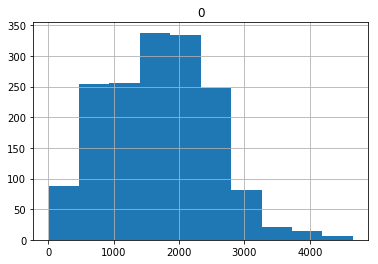

In [69]:
pd.DataFrame(L).hist()
plt.title('Train set length')

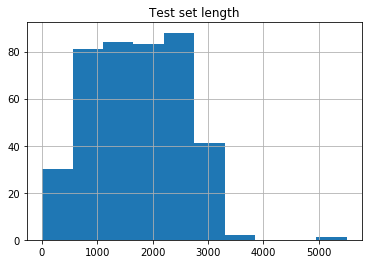

In [75]:
pd.DataFrame(Ltest).hist()
plt.title('Test set length')

# RNN classifier

In [25]:
#c_sess.close()

In [13]:
logs_path = '~/tensorboard/cl/12'

In [18]:
batch_size = 128
lstm_size = 128
c_graph = tf.Graph()
with c_graph.as_default():
    text_input = tf.placeholder(tf.int32, shape=[None, None])
    text_length = tf.placeholder(tf.float32, shape=[None])
    ans_input = tf.placeholder(tf.int32, shape=[None])
    do_update = tf.placeholder(tf.float32, shape=[None])
    keep_prob = tf.placeholder(tf.float32)
    cell_state = tf.placeholder(tf.float32, [batch_size, lstm_size])
    hidden_state = tf.placeholder(tf.float32, [batch_size, lstm_size])
    initial_state = tf.contrib.rnn.LSTMStateTuple(cell_state, hidden_state)
    
    labels = tf.one_hot(ans_input, num_classes)
    
    emb_words   = tf.Variable(final_embeddings, name = "embeddings", trainable = True, dtype = tf.float32)
    emb_padding = tf.Variable(1. * np.zeros((1, embedding_size)), trainable = False, dtype = tf.float32)
    embeddings = tf.concat([emb_words, emb_padding], 0)
    
    word_vectors = tf.reshape(tf.nn.embedding_lookup(embeddings, text_input), [-1, num_steps, embedding_size])
    word_list = tf.unstack(tf.nn.dropout(word_vectors, keep_prob), axis = 1)
    
    # LSTM
    cell = tf.contrib.rnn.LSTMCell(num_units = lstm_size)
    _, current_state = tf.contrib.rnn.static_rnn(cell, word_list, initial_state = initial_state,
                                               sequence_length = text_length)
    out = current_state[1]
    # /LSTM
    
    num_updates = tf.reduce_sum(do_update)
    
    dense = tf.nn.dropout(tf.layers.dense(inputs = out, units=64, activation=tf.nn.relu), keep_prob)
    logits = tf.contrib.layers.fully_connected(dense, num_classes, activation_fn = None)
    
    sm_loss = tf.nn.softmax_cross_entropy_with_logits(labels = labels, logits = logits)
    loss = tf.reduce_mean(tf.transpose((tf.transpose(sm_loss) * do_update))) / (num_updates + 0.001) * batch_size
    
    optimizer = tf.train.RMSPropOptimizer(0.01).minimize(loss)
    
    tf.summary.scalar("Classification_loss", loss)
    summary = tf.summary.merge_all()
    v_summary = tf.summary.scalar("valid_loss", loss)
    
    answer = tf.argmax(logits, 1)
    probability = tf.nn.softmax(logits)
    
    initializer = tf.global_variables_initializer()
    writer = tf.summary.FileWriter(logs_path, c_graph)

In [19]:
def get_minibatch(X, Y, L, size = batch_size):
    N = len(X)
    start_idx = 0
    while start_idx < N:
        do_clear_state = 1
        idx = range(start_idx, start_idx + size)
        if np.max(idx) >= N:
            break
        max_len = np.max(L[idx])
        start_pos = 0
        while start_pos < max_len:
            X_ = []
            L_ = []
            Last = []
            for i in idx:
                v = X[i][start_pos : min(start_pos + num_steps, L[i])]
                if start_pos + num_steps >= L[i] and start_pos < L[i]:
                    Last.append(1)
                else:
                    Last.append(0)
                L_.append(len(v))
                v += [pad_word] * (num_steps - len(v))
                X_.append(v)
            yield np.array(X_), Y[idx], np.array(L_), do_clear_state, np.array(Last)
            do_clear_state = 0
            start_pos += num_steps
        start_idx += size

In [ ]:
c_sess = tf.Session(graph=c_graph)
c_sess.run(initializer)
rolling_epoch = 0
_current_cell_state = np.zeros((batch_size, lstm_size))
_current_hidden_state = np.zeros((batch_size, lstm_size))

In [ ]:
valid_idx = random.sample(range(len(X)), 100)
train_idx = np.setdiff1d(np.arange(X.shape[0]), valid_idx)

while True:
    for X_, Y_, L_, do_clear_state, Last in get_minibatch(X[train_idx], Y[train_idx], L[train_idx], batch_size):
        feed_dict = {text_input: X_, ans_input: Y_, text_length: L_,
                     cell_state: _current_cell_state, hidden_state: _current_hidden_state, keep_prob: 0.5,
                    #do_update: 1. * (L_ > 0)}
                     do_update: Last}
        
        n, _, l, s, c_state = c_sess.run([num_updates, optimizer, loss, summary, current_state], feed_dict = feed_dict)
        _current_cell_state, _current_hidden_state = c_state
        if n > 0:
            writer.add_summary(s, rolling_epoch)
        
        rolling_epoch += 1
        print(n, rolling_epoch, l, do_clear_state)

0.0 1 0.0 1
0.0 2 0.0 0
0.0 3 0.0 0
1.0 4 2.08592 0
0.0 5 0.0 0
0.0 6 0.0 0
1.0 7 2.07634 0
1.0 8 2.05902 0
1.0 9 2.0452 0
1.0 10 2.12533 0
2.0 11 2.04053 0
0.0 12 0.0 0
0.0 13 0.0 0
0.0 14 0.0 0
3.0 15 2.06762 0
1.0 16 2.04921 0
3.0 17 2.05207 0
1.0 18 1.99307 0
3.0 19 2.04567 0
3.0 20 2.01968 0
1.0 21 1.86182 0
3.0 22 2.08992 0
1.0 23 2.09329 0
1.0 24 2.16966 0
1.0 25 1.95685 0
2.0 26 1.70712 0
2.0 27 1.61739 0
1.0 28 1.75379 0
2.0 29 1.83467 0
2.0 30 2.29189 0
2.0 31 1.67673 0
1.0 32 1.71337 0
0.0 33 0.0 0
1.0 34 2.34361 0
1.0 35 1.44821 0
0.0 36 0.0 0
0.0 37 0.0 0
0.0 38 0.0 0
0.0 39 0.0 0
2.0 40 1.70888 0
1.0 41 2.57004 0
0.0 42 0.0 0
1.0 43 1.91807 0
0.0 44 0.0 0
0.0 45 0.0 0
1.0 46 1.52675 0
2.0 47 1.3873 0
0.0 48 0.0 0
3.0 49 2.0818 0
3.0 50 1.39987 0
1.0 51 1.45636 0
1.0 52 1.042 0
2.0 53 3.28305 0
1.0 54 1.09535 0
1.0 55 0.995346 0
2.0 56 0.853368 0
3.0 57 1.48504 0
1.0 58 0.829235 0
1.0 59 3.52561 0
2.0 60 0.681071 0
3.0 61 0.696298 0
4.0 62 0.221939 0
0.0 63 0.0 0
0.0 64 0.

# Classifying test data

In [125]:
def classify_idx(X, L, idx):
    start_pos = 0
    max_len = min(np.max(L[idx]), 100)
    _current_cell_state = np.zeros((batch_size, lstm_size))
    _current_hidden_state = np.zeros((batch_size, lstm_size))
    res = np.zeros((batch_size, num_classes))
    while start_pos < max_len:
        #print(start_pos)
        X_ = []
        L_ = []
        
        for i in idx:
            v = X[i][start_pos : min(start_pos + num_steps, L[i])]
            L_.append(len(v))
            v += [pad_word] * (num_steps - len(v))
            X_.append(v)
    
        feed_dict = {text_input: X_, text_length: L_, cell_state: _current_cell_state,
                     hidden_state: _current_hidden_state, keep_prob: 1}
        
        ll, c_state = c_sess.run([probability, current_state], feed_dict = feed_dict)
        _current_cell_state, _current_hidden_state = c_state
        
        print(ll)
        
        res += ll
        
        start_pos += num_steps
    #print(ll)
    answers = np.argmax(ll, axis = 1)
    return(answers)

In [ ]:
classify_idx(X, L, range(1000,1000+64))

In [131]:
tf.InteractiveSession()

In [152]:
X = tf.Variable(np.array([[1.,2,3],[4,5,6],[9, 8, 7]]))

In [156]:
y = tf.Variable(np.array([0.,1, 2]))

In [157]:
X.initializer.run()
y.initializer.run()

In [158]:
tf.transpose((tf.transpose(X) * y)).eval()

array([[  0.,   0.,   0.],
       [  4.,   5.,   6.],
       [ 18.,  16.,  14.]])

In [34]:
c_sess.close()